In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import pygenometracks.tracks as pygtk
import topmed_manuscript_clean as tm
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import conversion, default_converter
from adjustText import adjust_text

PREFIX = 'Fig1C.'
GTF = '../../manuscript-intermediate-processing/data/gtf/gencode.v30.GRCh38.ERCC.genes.collapsed_only.gtf.gz'
GENE_BED = '/net/topmed10/working/porchard/rnaseq/data/gtf/collapsed.names.bed'
PANUKBB_FINEMAPPING_DIR = '/net/topmed11/working/porchard/panukbb-finemapping'
#COLOC_GWAS = '/net/topmed11/working/porchard/coloc/notebooks/postprocess-panukbb-topmed-coloc.joint.postprocessed.txt'
#COLOC_CIS_TRANS = '/net/topmed11/working/porchard/coloc/notebooks/postprocess-xqtl-coloc.joint.postprocessed.txt'
COLOC_GWAS = '../../manuscript-intermediate-processing/work/coloc/panukbb/joint/postprocessed.txt'
COLOC_CIS_TRANS = '../../manuscript-intermediate-processing/work/coloc/xqtl/joint/postprocessed.txt'
GWAS_MANIFEST = f'{PANUKBB_FINEMAPPING_DIR}/work/selected-traits/manifest.EUR.txt'


def get_ukbb_ld_matrix_in_hg38(hg38_chrom, hg38_start, hg38_end):
    # get the hg19 region coordinates
    hg19_to_hg38 = pd.read_csv(os.path.join(PANUKBB_FINEMAPPING_DIR, 'work/ancestry-specific-finemapping/lift-susie/results/lifted-regions/regions-hg38.bed'), sep='\t', header=None, names=['chrom', 'start', 'end', 'hg19'])
    gwas_region_hg19 = hg19_to_hg38[(hg19_to_hg38.chrom==hg38_chrom) & (hg19_to_hg38.start==int(hg38_start)) & (hg19_to_hg38.end==int(hg38_end))].hg19.values[0]

    # get the hg19 --> hg38 variant conversions
    snp_conversions = tm.tabix(os.path.join(PANUKBB_FINEMAPPING_DIR, 'work/lift/variants/results/conversion-table/snp-names.txt.gz'), f'{hg38_chrom}:{hg38_start}-{hg38_end}').iloc[:,[6,7]]
    snp_conversions.columns = ['hg38', 'hg19']
    # remove any non one-to-one mappings
    snp_conversions = snp_conversions[~snp_conversions.hg19.duplicated(keep=False)]
    snp_conversions = snp_conversions[~snp_conversions.hg38.duplicated(keep=False)]
    hg19_to_hg38_variants = dict(zip(snp_conversions.hg19, snp_conversions.hg38))

    # get UKBB LD
    ukbb_ld = pd.read_csv(os.path.join(PANUKBB_FINEMAPPING_DIR, 'work/ancestry-specific-finemapping/ld-matrices/results/ld-matrix/{}___EUR.ld.tsv.bgz'.format(gwas_region_hg19.replace('chr', '').replace(':', '_'))), sep='\t', header=None, compression='gzip', dtype=float)
    ukbb_ld_variants = pd.read_csv(os.path.join(PANUKBB_FINEMAPPING_DIR, 'work/ancestry-specific-finemapping/ld-matrices/results/ld-matrix/{}___EUR.variants.tsv.gz'.format(gwas_region_hg19.replace('chr', '').replace(':', '_'))), sep='\t')
    ukbb_ld.columns = 'chr' + ukbb_ld_variants.variant_id.values
    ukbb_ld.index = 'chr' + ukbb_ld_variants.variant_id.values

    assert(ukbb_ld.columns.to_series().map(lambda x: x in hg19_to_hg38_variants).mean() >= 0.99)
    ukbb_ld = ukbb_ld.loc[ukbb_ld.index.to_series().map(lambda x: x in hg19_to_hg38_variants),ukbb_ld.columns.to_series().map(lambda x: x in hg19_to_hg38_variants)]
    ukbb_ld.columns = [hg19_to_hg38_variants[i] for i in ukbb_ld.columns]
    ukbb_ld.index = [hg19_to_hg38_variants[i] for i in ukbb_ld.index]

    # make symmetric
    ukbb_ld_symmetric = ukbb_ld + ukbb_ld.T
    for i in range(ukbb_ld_symmetric.shape[0]):
        ukbb_ld_symmetric.iat[i,i] /= 2

    return ukbb_ld_symmetric

def load_susieR_lbf_matrix(rda):
    df = None
    with conversion.localconverter(default_converter):
        pandas2ri.activate()
        base = importr('base')
        base.load(rda)
        tmp = robjects.r['susie_out']
        key_to_index = {k: i for i, k in enumerate(tmp.names)}

        lbf_variable = tmp[key_to_index['lbf_variable']]
        variants = robjects.r('colnames(susie_out$lbf_variable)')
        with (robjects.default_converter + pandas2ri.converter).context():
            df = robjects.conversion.get_conversion().rpy2py(lbf_variable)
            df = pd.DataFrame(df)
            df.columns = robjects.conversion.get_conversion().rpy2py(variants)
            df.index = [f'L{i}' for i in range(1, len(df)+1)]
    
    return df


def get_lbf_df(susie_gene_result):
    df = pd.DataFrame(susie_gene_result['lbf_variable'])
    df.index = susie_gene_result['sets']['purity'].index
    df.columns = susie_gene_result['pip'].index
    return df

/net/snowwhite/home/porchard/anaconda3/envs/2020-09/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/net/snowwhite/home/porchard/anaconda3/envs/2020-09/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /net/snowwhite/home/porchard/anaconda3/envs/2020-09/lib/R
INFO:rpy2.situation:R library path: 
INFO:rpy2.situation:LD_LIBRARY_PATH: 
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
INFO:rpy2.ri

In [2]:
track_config = dict(file=GENE_BED, arrow_length=1000, arrow_interval=10, file_type='bed', height=3, color='black', merge_transcripts=False, labels=True, section_name='', prefered_name='gene_name', global_max_row=False, fontstyle='italic', font_size=8
, style="UCSC", all_labels_inside=False, labels_in_margin=True)
tk = pygtk.BedTrack(track_config)

gtf_df = tm.gtf_to_df(GTF, parse_attributes=['gene_id', 'gene_name'])
gene_id_to_gene_name = dict(zip(gtf_df.gene_id, gtf_df.gene_name))

100%|██████████| 58103/58103 [00:02<00:00, 21906.72it/s]


In [3]:
coloc_gwas = pd.read_csv(COLOC_GWAS, sep='\t')
coloc_cis_trans = pd.read_csv(COLOC_CIS_TRANS, sep='\t')
coloc_cis_trans = coloc_cis_trans[(coloc_cis_trans.xqtl1_tissue=='Whole_blood') & (coloc_cis_trans.xqtl2_tissue=='Whole_blood') & (coloc_cis_trans.xqtl1_modality=='ciseqtl') & (coloc_cis_trans.xqtl2_modality=='transeqtl')]
coloc_gwas = coloc_gwas[(coloc_gwas.xqtl_tissue=='Whole_blood') & (coloc_gwas.xqtl_modality=='ciseqtl') & (coloc_gwas.xqtl_maf=='1%')]

In [4]:
gwas_manifest = pd.read_csv(GWAS_MANIFEST, sep='\t')

In [5]:
CIS_PHENOTYPE = 'ENSG00000146592.17'
TRANS_PHENOTYPE = 'ENSG00000140443.14'
GWAS_TRAIT = 'continuous-30200-both_sexes-irnt'

assert(coloc_gwas[(coloc_gwas.xqtl_phenotype==CIS_PHENOTYPE) & (coloc_gwas.gwas_trait==GWAS_TRAIT)].gwas_signal.nunique() == 1)
GWAS_TRAIT_AND_REGION = coloc_gwas[(coloc_gwas.xqtl_phenotype==CIS_PHENOTYPE) & (coloc_gwas.gwas_trait==GWAS_TRAIT)].gwas_signal.unique()[0]
CIS_CS = coloc_cis_trans[(coloc_cis_trans.xqtl1_phenotype==CIS_PHENOTYPE) & (coloc_cis_trans.xqtl2_phenotype==TRANS_PHENOTYPE)].sort_values('xqtl1_cs').xqtl1_cs.to_list()
TRANS_CS = coloc_cis_trans[(coloc_cis_trans.xqtl1_phenotype==CIS_PHENOTYPE) & (coloc_cis_trans.xqtl2_phenotype==TRANS_PHENOTYPE)].sort_values('xqtl1_cs').xqtl2_cs.to_list()
GWAS_CS = coloc_gwas[(coloc_gwas.xqtl_phenotype==CIS_PHENOTYPE) & (coloc_gwas.gwas_trait==GWAS_TRAIT)].sort_values('xqtl_cs').gwas_cs.to_list()
GWAS_RDA = f'/net/topmed11/working/porchard/panukbb-finemapping/work/ancestry-specific-finemapping/lift-susie/results/susie-hg38/{GWAS_TRAIT_AND_REGION}.rda'
CHROM, START, END = GWAS_TRAIT_AND_REGION.split('___')[-1].split('_')
GWAS_TRAIT_NAME = gwas_manifest[gwas_manifest.trait_id==GWAS_TRAIT].description.values[0].replace('percentage', '%')

In [6]:
ukbb_ld = get_ukbb_ld_matrix_in_hg38(CHROM, START, END)

In [7]:
# load CS
with open('../../manuscript-intermediate-processing/data/scan-results/joint/cis-eqtl/susie/maf001/Whole_blood.100.susie.pickle', 'rb') as f:
    cis_effects = pickle.load(f)
with open('../../manuscript-intermediate-processing/data/scan-results/joint/trans-eqtl/maf005/trans-susie/Whole_blood.susie.pickle', 'rb') as f:
    trans_effects = pickle.load(f)

In [8]:
cis_lbf_matrix = get_lbf_df(cis_effects[CIS_PHENOTYPE])
trans_lbf_matrix = get_lbf_df(trans_effects[TRANS_PHENOTYPE])
gwas_lbf_matrix = load_susieR_lbf_matrix(GWAS_RDA)

/net/snowwhite/home/porchard/anaconda3/envs/2020-09/lib/python3.8/site-packages/rpy2/robjects/vectors.py:1016: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/net/snowwhite/home/porchard/anaconda3/envs/2020-09/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2211: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data.ravel("K"))


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 10.28,-0.08
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 10.28,-0.08
<ipython-input-1-370275f9362d>:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


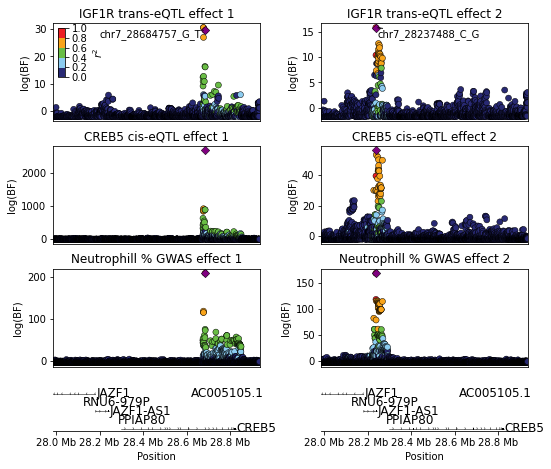

In [9]:
cmap, norm = tm.make_locuszoom_cmap_and_norm(default=True)
kwargs = {'hue': 'ld', 'palette': cmap, 'hue_norm': norm, 'legend': False, 'edgecolor': 'black'}
lead_variant_kwargs = {'legend': False, 'edgecolor': 'black', 'marker': 'D', 'color': 'purple'}

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(8.5, 7.5), gridspec_kw={'height_ratios': [1, 1, 1, 0.4], 'hspace': 0.3, 'wspace': 0.3})

for i, (cis_cs, trans_cs, gwas_cs) in enumerate(zip(CIS_CS, TRANS_CS, GWAS_CS)):
    cis_df = cis_lbf_matrix.loc[cis_cs].to_frame().rename(columns={cis_cs: 'cis'})
    cis_df['pos'] = cis_df.index.to_series().str.split('_', expand=True)[1].astype(int)

    trans_df = trans_lbf_matrix.loc[trans_cs].to_frame().rename(columns={trans_cs: 'trans'})
    trans_df['pos'] = trans_df.index.to_series().str.split('_', expand=True)[1].astype(int)

    gwas_df = gwas_lbf_matrix.loc[gwas_cs].to_frame().rename(columns={gwas_cs: 'gwas'})
    gwas_df['pos'] = gwas_df.index.to_series().str.split('_', expand=True)[1].astype(int)

    cis_lead_variant = cis_df.sort_values('cis', ascending=False).index[0]
    trans_lead_variant = trans_df.sort_values('trans', ascending=False).index[0]
    gwas_lead_variant = gwas_df.sort_values('gwas', ascending=False).index[0]

    assert(cis_lead_variant in ukbb_ld.index)
    assert(trans_lead_variant in ukbb_ld.index)
    assert(gwas_lead_variant in ukbb_ld.index)
    ld = ukbb_ld.loc[cis_lead_variant].abs().to_dict()

    cis_df['ld'] = cis_df.index.to_series().map(ld)
    trans_df['ld'] = trans_df.index.to_series().map(ld)
    gwas_df['ld'] = gwas_df.index.to_series().map(ld)

    XMIN = max([cis_df.pos.min(), trans_df.pos.min(), gwas_df.pos.min()])
    XMAX = min([cis_df.pos.max(), trans_df.pos.max(), gwas_df.pos.max()])


    ax = axs[0, i]
    sns.scatterplot(data=trans_df, x='pos', y='trans', ax=ax, **kwargs)
    sns.scatterplot(data=trans_df.loc[[cis_lead_variant]], x='pos', y='trans', ax=ax, **lead_variant_kwargs)
    ax.set_xlim(XMIN, XMAX)
    ax.set_ylabel(f'log(BF)')
    ax.set_title(f'{gene_id_to_gene_name[TRANS_PHENOTYPE]} trans-eQTL effect {i+1}')
    ax.xaxis.set_major_formatter(tm.pos_formatter)
    ax.set_xlabel('')
    ax.set_xticks([])
    if i == 0:
        cax = inset_axes(ax, width="3%", height="50%", loc='upper left')
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical', label='$r^2$')


    texts = [ax.text(x=trans_df.loc[cis_lead_variant].pos, y=trans_df.loc[cis_lead_variant].trans, s=cis_lead_variant)]
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), ax=ax, x=trans_df['pos'].to_list(), y=trans_df.trans.to_list())

    ax = axs[1, i]
    sns.scatterplot(data=cis_df[cis_df.index!=cis_lead_variant], x='pos', y='cis', ax=ax, **kwargs)
    sns.scatterplot(data=cis_df.loc[[cis_lead_variant]], x='pos', y='cis', ax=ax, **lead_variant_kwargs)
    ax.set_xlim(XMIN, XMAX)
    ax.set_ylabel(f'log(BF)')
    ax.set_title(f'{gene_id_to_gene_name[CIS_PHENOTYPE]} cis-eQTL effect {i+1}')
    ax.xaxis.set_major_formatter(tm.pos_formatter)
    ax.set_xlabel('')
    ax.set_xticks([])

    ax = axs[2, i]
    sns.scatterplot(data=gwas_df, x='pos', y='gwas', ax=ax, **kwargs)
    sns.scatterplot(data=gwas_df.loc[[cis_lead_variant]], x='pos', y='gwas', ax=ax, **lead_variant_kwargs)
    ax.set_xlim(XMIN, XMAX)
    ax.set_ylabel(f'log(BF)')
    ax.set_title(f'{GWAS_TRAIT_NAME} GWAS effect {i+1}')
    ax.xaxis.set_major_formatter(tm.pos_formatter)
    ax.set_xlabel('')
    ax.set_xticks([])


    # gene model
    ax = axs[3, i]
    XLIMS = [XMIN, XMAX]
    ax.set_xlim(XLIMS)
    tk.plot(ax, CHROM, XMIN, XMAX)
    ax.xaxis.set_major_formatter(tm.pos_formatter)
    ax.set_xlabel('Position')
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()
fig.savefig(f'figures/{PREFIX}png',dpi=300, facecolor='white', bbox_inches='tight')